In [2]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [ ]:
mat_file_list = [
    'arrhythmia.mat',
    'breastw.mat',
    'glass.mat',
    'ionosphere.mat',
    'letter.mat',
    'mammography.mat',
    'mnist.mat',
    'satellite.mat'
]

random_state = np.random.RandomState(42)

df_columns = ['Dataset', '#Samples', '#Dimensions', '%Outliers',
              'KNN', 'PCA', 'OCSVM', 'LOF', 'HBOS', 'IFOREST', 'SO_GAAL', 'MO_GAAL']
roc_df = pd.DataFrame(columns=df_columns)
prn_df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)


for mat_file in mat_file_list:
    print("\n... Processing", mat_file, '...')
    mat = loadmat(os.path.join('datasets', 'odds', mat_file))

    X = mat['X']
    y = mat['y'].ravel()
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)

    # construct containers for saving results
    roc_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    prn_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    time_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

    # 75% data for training and 25% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=random_state)

    # standardizing data for processing, mean=0, var=1
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    classifiers = {
        'k-Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Principal Component Analysis (PCA)': PCA(
            contamination=outliers_fraction,
            random_state=random_state
        ),
        'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)': LOF(contamination=outliers_fraction),
        'Histogram-Based Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(
            contamination=outliers_fraction,
            random_state=random_state
        ),
        'Single-Objective Generative Adversarial Active Learning (SO-GAAL)': SO_GAAL(contamination=outliers_fraction),
        'Multiple-Objective Generative Adversarial Active Learning (MO-GAAL)': MO_GAAL(contamination=outliers_fraction)
    }

    for clf_name, clf in classifiers.items():
        t0 = time()
        clf.fit(X_train_norm)
        test_scores = clf.decision_function(X_test_norm)
        t1 = time()
        duration = round(t1 - t0, ndigits=4)
        time_list.append(duration)

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

        print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
              'execution time: {duration}s'.format(
            clf_name=clf_name, roc=roc, prn=prn, duration=duration))

        roc_list.append(roc)
        prn_list.append(prn)

    temp_df = pd.DataFrame(time_list).transpose()
    temp_df.columns = df_columns
    time_df = pd.concat([time_df, temp_df], axis=0)

    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

    temp_df = pd.DataFrame(prn_list).transpose()
    temp_df.columns = df_columns
    prn_df = pd.concat([prn_df, temp_df], axis=0)


... Processing arrhythmia.mat ...
k-Nearest Neighbors (KNN) ROC:0.7555, precision @ rank n:0.5294, execution time: 0.0532s
Principal Component Analysis (PCA) ROC:0.7794, precision @ rank n:0.5882, execution time: 0.0498s
One-class SVM (OCSVM) ROC:0.7825, precision @ rank n:0.5882, execution time: 0.0433s
Local Outlier Factor (LOF) ROC:0.7672, precision @ rank n:0.4706, execution time: 0.0535s
Histogram-Based Outlier Detection (HBOS) ROC:0.7831, precision @ rank n:0.5882, execution time: 1.169s
Isolation Forest ROC:0.7849, precision @ rank n:0.4706, execution time: 0.265s
Epoch 1 of 60

Testing for epoch 1 index 1:
Epoch 2 of 60

Testing for epoch 2 index 1:
Epoch 3 of 60

Testing for epoch 3 index 1:
Epoch 4 of 60

Testing for epoch 4 index 1:
Epoch 5 of 60

Testing for epoch 5 index 1:
Epoch 6 of 60

Testing for epoch 6 index 1:
Epoch 7 of 60

Testing for epoch 7 index 1:
Epoch 8 of 60

Testing for epoch 8 index 1:
Epoch 9 of 60

Testing for epoch 9 index 1:
Epoch 10 of 60

Testing f

339/339 [==============================] - 0s 32us/step
Epoch 25 of 60

Testing for epoch 25 index 1:
339/339 [==============================] - 0s 19us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
339/339 [==============================] - 0s 33us/step
Epoch 27 of 60

Testing for epoch 27 index 1:
339/339 [==============================] - 0s 37us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
339/339 [==============================] - 0s 19us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
339/339 [==============================] - 0s 36us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
339/339 [==============================] - 0s 19us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
339/339 [==============================] - 0s 32us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
339/339 [==============================] - 0s 18us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
339/339 [==============================] - 0s 20us/step
Epoch 34 of 60

Testing fo

339/339 [==============================] - 0s 20us/step
Epoch 39 of 60

Testing for epoch 39 index 1:
339/339 [==============================] - 0s 19us/step
Epoch 40 of 60

Testing for epoch 40 index 1:
339/339 [==============================] - 0s 29us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
339/339 [==============================] - 0s 18us/step
Epoch 42 of 60

Testing for epoch 42 index 1:
339/339 [==============================] - 0s 53us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
339/339 [==============================] - 0s 18us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
339/339 [==============================] - 0s 32us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
339/339 [==============================] - 0s 28us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
339/339 [==============================] - 0s 21us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
339/339 [==============================] - 0s 48us/step
Epoch 48 of 60

Testing fo

339/339 [==============================] - 0s 34us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
339/339 [==============================] - 0s 23us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
339/339 [==============================] - 0s 36us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
339/339 [==============================] - 0s 24us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
339/339 [==============================] - 0s 62us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
339/339 [==============================] - 0s 31us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
339/339 [==============================] - 0s 33us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
339/339 [==============================] - 0s 36us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
339/339 [==============================] - 0s 19us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
339/339 [==============================] - 0s 19us/step
Multiple-Objective Generat

500/500 [==============================] - 0s 11us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 18us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
500/500 [==============================] - 0s 20us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 21us/step
Epoch 39 of 60

Testing fo

500/500 [==============================] - 0s 14us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
500/500 [==============================] - 0s 19us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 22us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [==============================] - 0s 13us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
500/500 [==============================] - 0s 13us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
500/500 [==============================] - 0s 20us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 19us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
500/500 [==============================] - 0s 13us/step
Epoch 38 of 60

Testing fo

500/500 [==============================] - 0s 24us/step
Epoch 42 of 60

Testing for epoch 42 index 1:
500/500 [==============================] - 0s 19us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
500/500 [==============================] - 0s 20us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
500/500 [==============================] - 0s 17us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
500/500 [==============================] - 0s 22us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
500/500 [==============================] - 0s 21us/step
Epoch 48 of 60

Testing for epoch 48 index 1:
500/500 [==============================] - 0s 16us/step
Epoch 49 of 60

Testing for epoch 49 index 1:
500/500 [==============================] - 0s 26us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
500/500 [==============================] - 0s 13us/step
Epoch 51 of 60

Testing fo

500/500 [==============================] - 0s 19us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
500/500 [==============================] - 0s 20us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
500/500 [==============================] - 0s 13us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 [==============================] - 0s 24us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
500/500 [==============================] - 0s 12us/step
Multiple-Objective Generative Adversarial Active Learning (MO-GAAL) ROC:0.0209, precision @ rank n:0.0, execution time: 16.1314s

... Processing glass.mat ...
k-Nearest Neighbors (KNN) ROC:0.8558, precision @ rank n:0.0, execution time: 0.0067s
Principal Component Analysis (PCA) ROC:0.7308, precision @ rank n:0.0, execution time: 0.0024s
One-class SVM (OCSVM) ROC:0.8077, precision @ rank n:0.0, execution time: 0.0049s
Local Outlie

160/160 [==============================] - 0s 15us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
160/160 [==============================] - 0s 16us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
160/160 [==============================] - 0s 14us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
160/160 [==============================] - 0s 17us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
160/160 [==============================] - 0s 14us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
160/160 [==============================] - 0s 14us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
160/160 [==============================] - 0s 44us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
160/160 [==============================] - 0s 19us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
160/160 [==============================] - 0s 16us/step
Single-Objective Generative Adversarial Active Learning (SO-GAAL) ROC:0.625, precision @ rank n:0.0, execution time: 2.5503s
Epo

## Таблицы для Latex'a

In [235]:
tmp = roc_df.copy()
for col in df_columns[3:]:
    tmp[col] = tmp[col].astype(float).round(4)
tmp

,Dataset,#Samples,#Dimensions,%Outliers,KNN,PCA,OCSVM,LOF,HBOS,IFOREST,SO_GAAL,MO_GAAL
0,arrhythmia,452,274,14.6018,0.7555,0.7794,0.7825,0.7672,0.7831,0.7849,0.5827,0.5429
0,breastw,683,9,34.9927,0.9908,0.9608,0.9649,0.4574,0.9764,0.9872,0.0186,0.0191
0,glass,214,9,4.2056,0.8558,0.7308,0.8077,0.6538,0.7500,0.7212,0.6538,0.7500
0,ionosphere,351,33,35.8974,0.9460,0.8115,0.8684,0.9023,0.6190,0.8632,0.7069,0.7103
0,letter,1600,32,6.2500,0.8660,0.5119,0.5985,0.8530,0.5532,0.5770,0.3004,0.3465
0,mammography,11183,6,2.3250,0.8346,0.9039,0.8911,0.6806,0.8506,0.8680,0.7852,0.8085
0,mnist,7603,100,9.2069,0.8322,0.8493,0.8487,0.6727,0.5607,0.7942,0.5981,0.6223
0,satellite,6435,36,31.6395,0.6795,0.5601,0.6274,0.5567,0.7464,0.7008,0.5975,0.6201


In [236]:
tmp_cols = ['Dataset']
tmp_cols.extend(list(df_columns[4:-2]))
print(tmp[tmp_cols].to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
     Dataset &     KNN &     PCA &   OCSVM &     LOF &    HBOS &  IFOREST \\
\midrule
  arrhythmia &  0.7555 &  0.7794 &  0.7825 &  0.7672 &  0.7831 &   0.7849 \\
     breastw &  0.9908 &  0.9608 &  0.9649 &  0.4574 &  0.9764 &   0.9872 \\
       glass &  0.8558 &  0.7308 &  0.8077 &  0.6538 &  0.7500 &   0.7212 \\
  ionosphere &  0.9460 &  0.8115 &  0.8684 &  0.9023 &  0.6190 &   0.8632 \\
      letter &  0.8660 &  0.5119 &  0.5985 &  0.8530 &  0.5532 &   0.5770 \\
 mammography &  0.8346 &  0.9039 &  0.8911 &  0.6806 &  0.8506 &   0.8680 \\
       mnist &  0.8322 &  0.8493 &  0.8487 &  0.6727 &  0.5607 &   0.7942 \\
   satellite &  0.6795 &  0.5601 &  0.6274 &  0.5567 &  0.7464 &   0.7008 \\
\bottomrule
\end{tabular}



In [232]:
print(tmp[df_columns[:4]].to_latex(index=False))

\begin{tabular}{lllr}
\toprule
     Dataset & \#Samples & \#Dimensions &  \%Outliers \\
\midrule
  arrhythmia &      452 &         274 &      14.60 \\
     breastw &      683 &           9 &      34.99 \\
       glass &      214 &           9 &       4.21 \\
  ionosphere &      351 &          33 &      35.90 \\
      letter &     1600 &          32 &       6.25 \\
 mammography &    11183 &           6 &       2.33 \\
       mnist &     7603 &         100 &       9.21 \\
   satellite &     6435 &          36 &      31.64 \\
\bottomrule
\end{tabular}



## Зависимость ROC-значения от сложности алгоритма

In [ ]:
from adjustText import adjust_text

models = df_columns[4:]

# ROC vs Time
fig = plt.figure(figsize=(15, 23))
for i, mat_file in enumerate(mat_file_list):
    fig.add_subplot("42{}".format(i + 1))
    data_title = mat_file[:-4]
    x = time_df[time_df['Dataset'] == data_title]
    y = roc_df[roc_df['Dataset'] == data_title]
    
    data_x = x[models].values[0][:-2]
    data_y = y[models].values[0][:-2]
    
    plt.title(
        "Датасет: {},\nКол-во объектов: {}, Размерность: {}".format(
            data_title,
            x[df_columns[1]][0],
            x[df_columns[2]][0]
        ),
        fontsize=15
    )
    plt.scatter(data_x, data_y, marker='*', color='blue')
    plt.xlabel("Время", fontsize=13)
    plt.ylabel("ROC", fontsize=13)
    texts = [plt.text(data_x[i], data_y[i], models[i], size=12) for i in range(len(models)-2)]
    adjust_text(texts)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
# plt.show()
plt.savefig('images/roc_vs_time.png', dpi=100)

# for mat_file in mat_file_list:
#     data_title = mat_file[:-4]
#     x = time_df[time_df['Dataset'] == data_title]
#     y = roc_df[roc_df['Dataset'] == data_title]
    
#     data_x = x[models].values[0][:-2]
#     data_y = y[models].values[0][:-2]
    
#     plt.figure(figsize=(8, 5))
#     plt.title(
#         "Датасет: {}, Кол-во объектов: {}, Размерность: {}".format(
#             data_title,
#             x[df_columns[1]][0],
#             x[df_columns[2]][0]
#         ),
#         fontsize=15
#     )
#     plt.scatter(data_x, data_y, marker='*', color='blue')
#     plt.xlabel("Время", fontsize=13)
#     plt.ylabel("ROC", fontsize=13)
#     texts = [plt.text(data_x[i], data_y[i], models[i], size=12) for i in range(len(models)-2)]
#     adjust_text(texts)
#     plt.show()

In [6]:
mat_file = 'satellite.mat'
mat = loadmat(os.path.join('datasets', mat_file))

X = mat['X']
y = mat['y'].ravel()
outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)

In [16]:
# 75% data for training and 25% for testing. Default values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=random_state)

# standardizing data for processing, mean=0, var=1
X_train_norm, X_test_norm = standardizer(X_train, X_test)

classifiers = {
    'Angle-based Outlier Detector (ABOD)': ABOD(
        contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(contamination=outliers_fraction, check_estimator=False,
                                                random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                      random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

In [24]:
# 'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state)
# 'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction)

clf_name, clf = ['Isolation Forest',
                 IForest(contamination=outliers_fraction, random_state=random_state)]

clf.fit(X_train_norm)
test_scores = clf.decision_function( X_test_norm)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision @ rank n:{prn}'.format(clf_name=clf_name, roc=roc, prn=prn))

Isolation Forest ROC:0.7231, precision @ rank n:0.5717


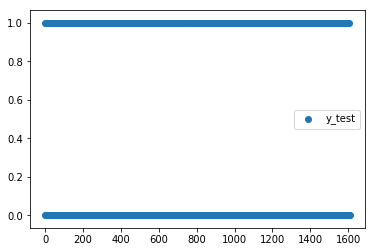

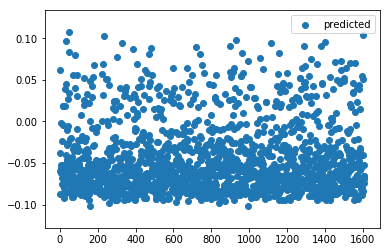

In [34]:
plt.scatter(range(len(y_test)), y_test, label='y_test')
# plt.scatter(range(len(test_scores)), test_scores, label='predicted')
plt.legend()
plt.show()

plt.scatter(range(len(test_scores)), test_scores, label='predicted')
plt.legend()
plt.show()

In [147]:
clf.stop_epochs

1000

In [3]:
from pyod.models.mo_gaal import MO_GAAL
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

contamination = 0.1  # percentage of outliers
n_train = 30000  # number of training points
n_test = 3000  # number of testing points
n_features = 2  # number of features

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=n_features,
                  contamination=contamination,
                  random_state=42)

clf_name = 'MO_GAAL'
clf = MO_GAAL(contamination=contamination, stop_epochs=2)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

Using TensorFlow backend.


Epoch 1 of 6

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Tes

500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 10:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 11:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 12:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 13:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 14:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 15:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 16:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 17:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 18:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 19:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 20:
500/500 [==============================] - 0s

500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 24:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 25:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 26:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 27:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 28:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 29:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 30:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 31:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 32:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 33:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 34:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 38:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 39:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 40:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 41:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 42:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 43:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 44:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 45:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 46:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 47:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 48:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 52:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 53:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 54:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 55:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 56:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 57:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 58:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 59:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 60:
500/500 [==============================] - 0s 10us/step
Epoch 4 of 6

Testing for epoch 4 index 1:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 2:
500/500 [=========================

500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 6:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 7:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 8:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 9:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 10:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 11:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 12:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 13:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 14:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 15:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 16:
500/500 [==============================] - 0s 11

500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 19:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 20:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 21:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 22:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 23:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 24:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 25:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 26:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 27:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 28:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 29:
500/500 [==============================] - 0s

500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 33:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 34:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 35:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 36:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 37:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 38:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 39:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 40:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 41:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 42:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 43:
500/500 [==============================] - 0

500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 47:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 48:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 49:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 50:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 51:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 52:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 53:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 54:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 55:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 56:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 57:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 10us/step
Epoch 5 of 6

Testing for epoch 5 index 1:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 2:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 3:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 4:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 5:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 6:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 7:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 8:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 9:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 10:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 11:
500/500 [==============================] 

500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 15:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 16:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 17:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 18:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 19:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 20:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 21:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 22:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 23:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 24:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 25:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 29:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 30:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 31:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 32:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 33:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 34:
500/500 [==============================] - 0s 12us/step

Testing for epoch 5 index 35:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 36:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 37:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 38:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 39:
500/500 [==============================] - 0s

500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 43:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 44:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 45:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 46:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 47:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 48:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 49:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 50:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 51:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 52:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 53:
500/500 [==============================] - 0

500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 57:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 58:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 59:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 60:
500/500 [==============================] - 0s 10us/step
Epoch 6 of 6

Testing for epoch 6 index 1:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 2:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 3:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 4:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 5:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 6:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 7:
500/500 [==============================

500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 10:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 11:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 12:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 13:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 14:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 15:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 16:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 17:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 18:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 19:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 20:
500/500 [==============================] - 0s 1

500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 24:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 25:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 26:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 27:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 28:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 29:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 30:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 31:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 32:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 33:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 34:
500/500 [==============================] - 0

500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 38:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 39:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 40:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 41:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 42:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 43:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 44:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 45:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 46:
500/500 [==============================] - 0s 12us/step

Testing for epoch 6 index 47:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 48:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 52:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 53:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 54:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 55:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 56:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 57:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 58:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 59:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 60:
500/500 [==============================] - 0s 11us/step

On Training Data:
MO_GAAL ROC:0.5459, precision @ rank n:0.5233

On Test Data:
MO_GAAL ROC:0.5069, precision @ rank n:0.4324


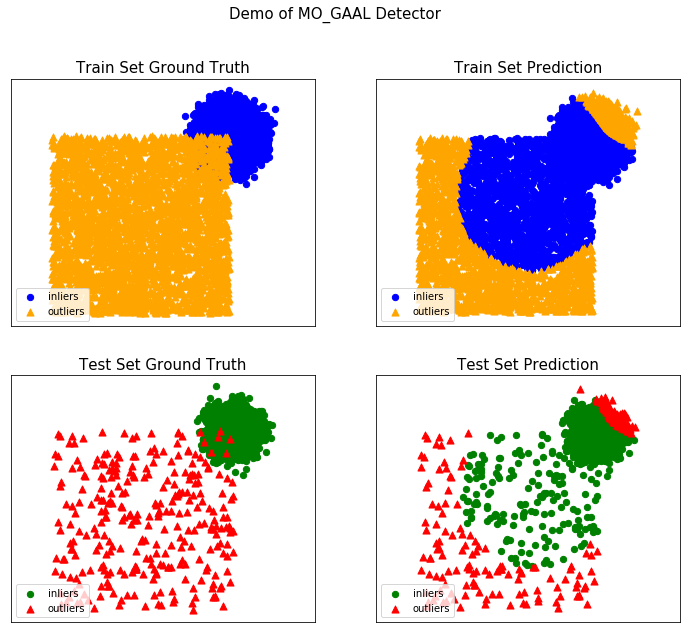

In [4]:
from pyod.utils.example import visualize

# visualize(clf_name,
#           X_train[:, :2], y_train,
#           X_test[:, :2], y_test,
#           y_train_pred, y_test_pred,
#           show_figure=True, save_figure=False)

visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [119]:
from pyod.models.so_gaal import SO_GAAL
from pyod.utils.data import evaluate_print, generate_data

X_train, y_train, X_test, y_test = generate_data(n_train=200, n_test=100,
                                                 n_features=2, contamination=0.2)

clf_name = 'SO_GAAL'
clf = SO_GAAL()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

Epoch 1 of 60

Testing for epoch 1 index 1:

On Training Data:
SO_GAAL ROC:0.1872, precision @ rank n:0.15

On Test Data:
SO_GAAL ROC:0.1488, precision @ rank n:0.05


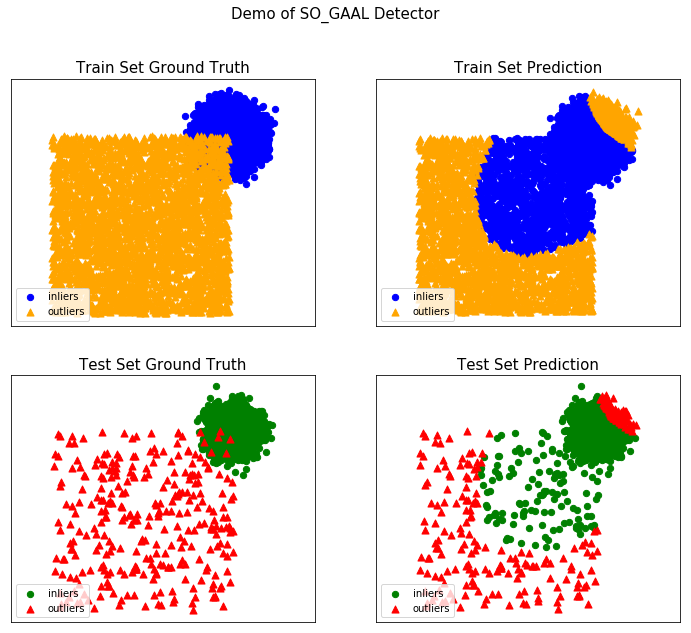

In [11]:
from pyod.utils.example import visualize

visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [ ]:
plt.figure(figsize=(15, 12))

scores_pred = clf.decision_function(X) * -1
y_pred = clf.predict(X)
threshold = percentile(scores_pred, 100 * outliers_fraction)
n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
subplot = plt.subplot(3, 4, i + 1)
subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                 cmap=plt.cm.Blues_r)
a = subplot.contour(xx, yy, Z, levels=[threshold],
                    linewidths=2, colors='red')
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                 colors='orange')
b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                    s=20, edgecolor='k')
c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                    s=20, edgecolor='k')
subplot.axis('tight')
subplot.legend(
    [a.collections[0], b, c],
    ['learned decision function', 'true inliers', 'true outliers'],
    prop=matplotlib.font_manager.FontProperties(size=10),
    loc='lower right')
subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
subplot.set_xlim((-7, 7))
subplot.set_ylim((-7, 7))

plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")
plt.show()

In [113]:
from pyod.models.knn import KNN   # kNN detector
from pyod.utils.data import evaluate_print, generate_data

X_train, y_train, X_test, y_test = generate_data(n_train=200, n_test=100,
                                                 n_features=2, contamination=0.2)

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.8839, precision @ rank n:0.7

On Test Data:
KNN ROC:0.9438, precision @ rank n:0.8


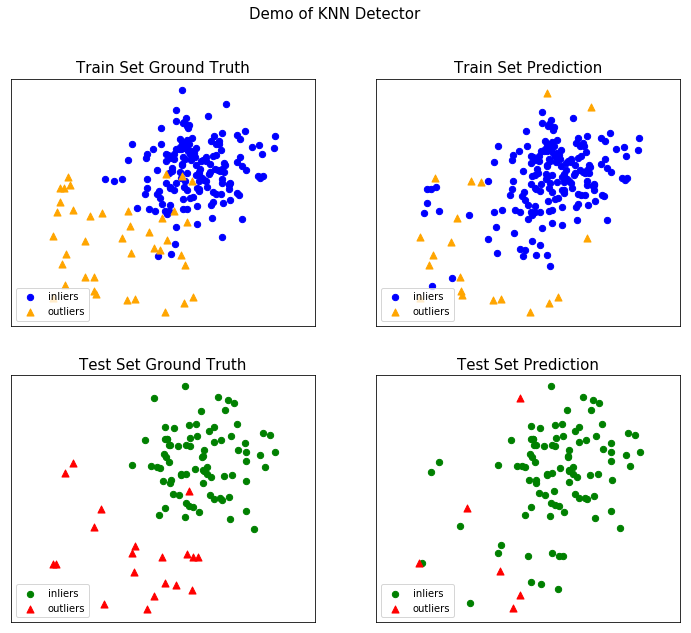

In [115]:
from pyod.utils.example import visualize

visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [79]:
X_train_norm, X_test_norm = standardizer(X_train, X_test)

In [80]:
clf_name, clf = ['Isolation Forest',
                 IForest(contamination=outliers_fraction, random_state=random_state)]

clf.fit(X_train_norm)
test_scores = clf.decision_function(X_test_norm)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision @ rank n:{prn}'.format(clf_name=clf_name, roc=roc, prn=prn))

Isolation Forest ROC:0.9733, precision @ rank n:0.7


In [98]:
clf.predict(X_test_norm[:10])

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [96]:
clf.predict_proba(X_test_norm[:10], method='unify')

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.89086876, 0.10913124],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.45691057, 0.54308943],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [81]:
clf.predict_proba(X_test_norm)

array([[0.9533114 , 0.0466886 ],
       [0.86425022, 0.13574978],
       [0.75418067, 0.24581933],
       [0.86354695, 0.13645305],
       [0.8570558 , 0.1429442 ],
       [0.87415439, 0.12584561],
       [0.94814323, 0.05185677],
       [0.6164816 , 0.3835184 ],
       [0.91709132, 0.08290868],
       [0.94487256, 0.05512744],
       [0.86511712, 0.13488288],
       [0.50731664, 0.49268336],
       [0.76362364, 0.23637636],
       [0.8205121 , 0.1794879 ],
       [0.93906991, 0.06093009],
       [0.91967204, 0.08032796],
       [0.82628898, 0.17371102],
       [0.88156937, 0.11843063],
       [0.89010898, 0.10989102],
       [0.89987263, 0.10012737],
       [0.96734497, 0.03265503],
       [0.95092351, 0.04907649],
       [0.91762442, 0.08237558],
       [0.93509042, 0.06490958],
       [0.91449328, 0.08550672],
       [0.26309336, 0.73690664],
       [0.66281329, 0.33718671],
       [0.91012464, 0.08987536],
       [0.93863431, 0.06136569],
       [0.92327983, 0.07672017],
       [0.

In [ ]:
roc_auc_score(y_true, y_scores)

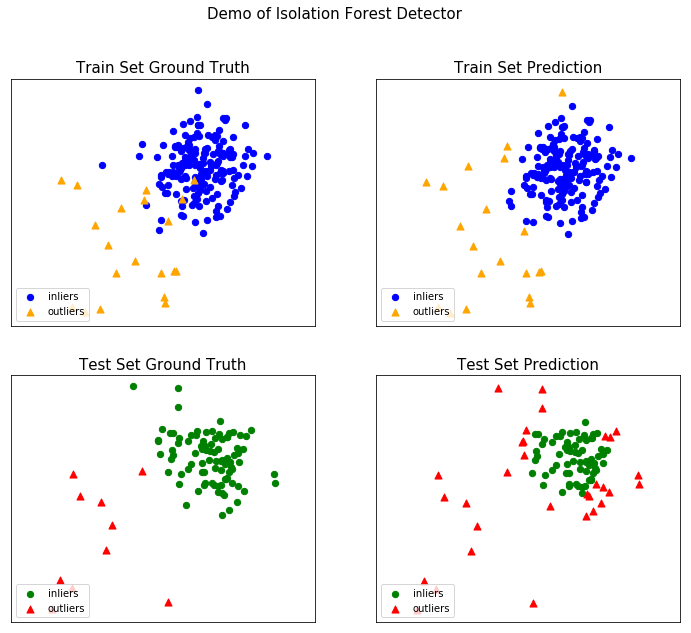

In [75]:
y_test_pred = clf.predict(X_test_norm)  # outlier labels (0 or 1)
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

## Представление многомерных данных из датасета

In [102]:
# import numpy as np
# from sklearn.manifold import TSNE
# from pyod.utils.data import get_outliers_inliers
# import tqdm

# after_tsne = dict()

# for mat_file in tqdm.tqdm(mat_file_list):
#     mat = loadmat(os.path.join('datasets', 'odds', mat_file))

#     X = mat['X']
#     y = mat['y'].ravel()

#     X_embedded = TSNE(n_components=2).fit_transform(X)

#     X_out, X_in = get_outliers_inliers(X_embedded, y)
#     after_tsne[mat_file] = (X_out, X_in)

100%|██████████| 8/8 [02:47<00:00, 32.69s/it]


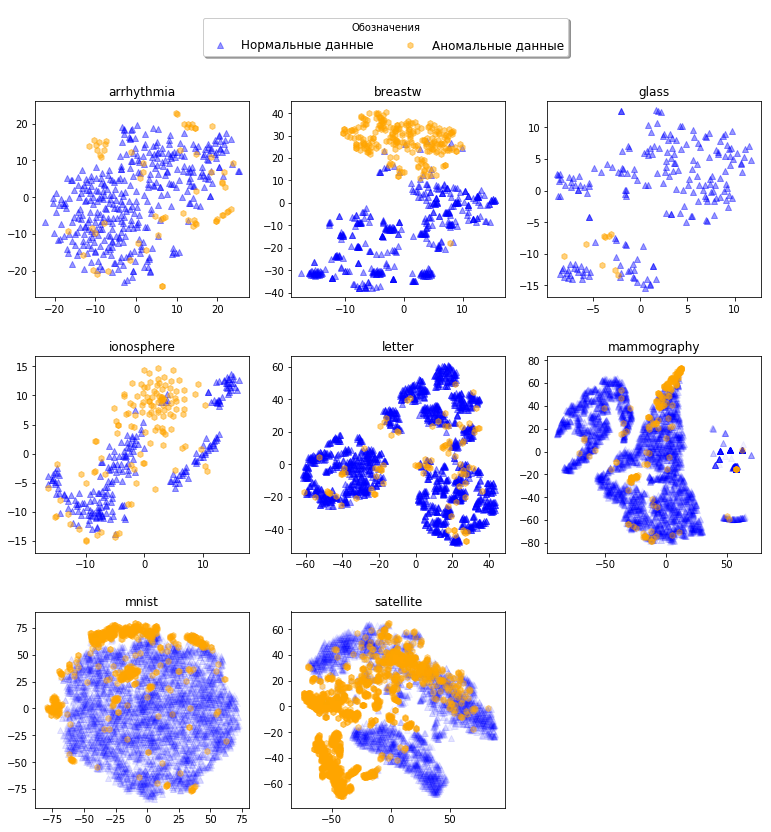

In [155]:
fig = plt.figure(figsize=(13, 13))
for i, mat_file in enumerate(mat_file_list):
    fig.add_subplot("33{}".format(i + 1))
    X_out, X_in = after_tsne[mat_file]
    if i > 4:
        plt.scatter(X_in[:, 0], X_in[:, 1], color='blue', marker='^', alpha=0.05)
        plt.scatter(X_out[:, 0], X_out[:, 1], color='orange', marker='h', alpha=0.4)
    else:
        plt.scatter(X_in[:, 0], X_in[:, 1], color='blue', marker='^', alpha=0.4)
        plt.scatter(X_out[:, 0], X_out[:, 1], color='orange', marker='h', alpha=0.5)
    plt.title(mat_file[:-4])
fig.legend(labels=['Нормальные данные', 'Аномальные данные'],
           loc=9, borderaxespad=1.5, title="Обозначения", shadow=True, ncol=3, fontsize=12)
plt.subplots_adjust(hspace=0.3)
# plt.show()
plt.savefig('images/2d_comparison.png', dpi=100)